In [2]:
import pandas as pd
import numpy as np
import os
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as LR
import warnings
warnings.filterwarnings('ignore')

In [2]:
os.environ['PYSPARK_PYTHON'] = '/home/luban/anaconda3/envs/python36/bin/python'
import findspark
findspark.init()

from pyspark import *
from pyspark.sql import *

app_name = 'lixiuhan'
conf = (SparkConf().setAppName(app_name)
        .set('spark.master', 'yarn')
        .set('spark.submit.deployMode', 'client')
        .set('spark.driver.memory',                  '8g')
        .set('spark.executor.memory',                '8g')
        .set('spark.dynamicAllocation.minExecutors', '100')
        .set('spark.dynamicAllocation.maxExecutors', '200')
        .set('spark.yarn.queue',                     'root.celuemoxingbu_driver_service_score_orig')
        .set('spark.ui.port','8060')
        .set('spark.executor.memoryOverhead','4096')
        .set("spark.sql.execution.arrow.pyspark.enabled", "true")
        .set('spark.driver.allowMultipleContexts', 'True')
        .set('spark.yarn.dist.archives','hdfs://DClusterNmg4/user/bigdata_driver_ecosys_test/ly/python_env/python3.6.2.tgz#python3.6.2')
        .set('spark.pyspark.driver.python',          '/home/luban/anaconda3/envs/python36/bin/python')
        .set('spark.pyspark.python', './python3.6.2/bin/python')
        .set("spark.yarn.appMasterEnv.PYSPARK_PYTHON", './python3.6.2/bin/python')
        )
spark = SparkSession.builder.config(conf = conf).enableHiveSupport().getOrCreate()
sc = spark.sparkContext

from pyspark.sql.functions import col,udf,date_sub,explode,split,date_add
from pyspark.sql.types import StringType,DoubleType,IntegerType
import pandas as pd
import numpy as np
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option('expand_frame_repr',False)
import matplotlib.pyplot as plt

from pyspark.sql import functions as F
hc = HiveContext(sc)

In [8]:
sql = \
'''
select  dt
		,city_id
		,product_line
		,bin_num
		,bin_type
		,user_cnt
		,compete_call_cnt
		,objective_call_cnt
		,ans_cnt
		,suc_cnt
		,gmv
		,subsidy_c
		,subsidy_b
		,subsidy_coupon
		,subsidy_hufan
		,business_profit
		,online_driver_divide
		,bubble_cnt
		,gmv_caiwu
		,order_charge_dis
		,driver_charge_dis
		,subsidy_c/gmv subsidy_c_rate
		,subsidy_b/gmv subsidy_b_rate
		,subsidy_coupon/gmv subsidy_coupon_rate
		,subsidy_hufan/gmv subsidy_hufan_rate
from	smt_stg.smt_city_subsidy_bin
where   dt between '{start_date}' and '{end_date}'
        and product_line in ({product_list})
        and city_id in ({city_list})
        and user_cnt > 100
        and subsidy_c/gmv < 0.4
'''.format(start_date='2023-03-31', 
           end_date='2023-06-26', 
           city_list=','.join([str(i) for i in range(1, 301)]),
           product_list='\'新泛快\'')

In [33]:
# df = hc.sql(sql).toPandas()
df = pd.read_csv('/home/luban/workspace/观测数据建模/drs/script/models/torch_nn/feature_20230331_20230626.csv')
df

,dt,city_id,product_line,bin_num,bin_type,user_cnt,compete_call_cnt,objective_call_cnt,ans_cnt,suc_cnt,...,subsidy_c,subsidy_b,subsidy_coupon,subsidy_hufan,business_profit,online_driver_divide,bubble_cnt,gmv_caiwu,order_charge_dis,driver_charge_dis
0,2023-05-24,235,新泛快,0,subsidy_c,5721,7571.0,7300.0,7353.0,6952.0,...,0.0300,740.796972,0.00,0.00,14664.241992,68373.68,23923.0,86728.37,29265110,29258070
1,2023-05-24,50,新泛快,343,subsidy_c,356,430.0,430.0,430.0,411.0,...,898.6200,2.951705,874.46,2.45,-427.563124,2074.49,1341.0,2616.94,838780,838790
2,2023-05-24,53,新泛快,204,subsidy_c,200,229.0,226.0,222.0,211.0,...,1171.0800,8.328168,999.92,976.05,797.040265,3589.82,794.0,5717.60,2481410,2481460
3,2023-05-24,7,新泛快,112,subsidy_c,119,296.0,291.0,278.0,266.0,...,850.7748,26.125251,681.03,388.82,1205.351568,5222.64,854.0,7561.36,2405610,2405610
4,2023-05-24,9,新泛快,164,subsidy_c,121,293.0,291.0,291.0,274.0,...,1137.6500,16.769986,865.78,310.72,759.835661,4775.42,956.0,6916.27,2764360,2764220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873311,2023-06-21,36,新泛快,52,subsidy_c,304,830.0,811.0,743.0,659.0,...,884.6300,1219.511071,681.75,134.44,1709.864988,12436.80,2262.0,16859.62,4934550,4934100
873312,2023-06-21,18,新泛快,348,subsidy_c,111,240.0,233.0,201.0,175.0,...,1607.5600,809.730357,1480.50,358.41,-1232.662814,3314.03,874.0,4612.86,1563730,1563650
873313,2023-06-21,253,新泛快,278,subsidy_c,151,177.0,176.0,172.0,158.0,...,1015.7100,144.663333,662.59,10.56,1.422914,2392.11,625.0,3646.07,1304740,1304850
873314,2023-06-21,254,新泛快,13,subsidy_c,104,256.0,256.0,228.0,214.0,...,36.8800,248.853334,1.63,1.63,384.506233,1968.98,758.0,2732.72,947390,947210


In [31]:
df.isna().sum()

dt                      0
city_id                 0
product_line            0
bin_num                 0
bin_type                0
user_cnt                0
compete_call_cnt        0
objective_call_cnt      0
ans_cnt                 0
suc_cnt                 0
gmv                     0
subsidy_c               0
subsidy_b               0
subsidy_coupon          0
subsidy_hufan           0
business_profit         0
online_driver_divide    0
bubble_cnt              0
gmv_caiwu               0
order_charge_dis        0
driver_charge_dis       0
dtype: int64

In [11]:
df.drop(columns=['subsidy_c_rate', 'subsidy_b_rate', 'subsidy_coupon_rate', 'subsidy_hufan_rate']).to_csv('feature_20230331_20230626.csv', index=False)

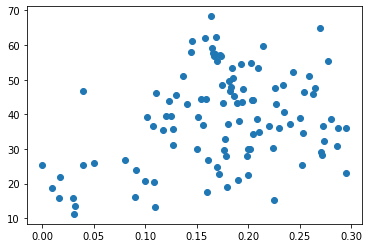

In [89]:
df2 = df[(df['city_id'] == 9) & (df['dt'] == '2023-06-12') & (df['user_cnt'] > 100) & (df['subsidy_c_rate'] < 0.3)].sort_values(by=['bin_num'])
plt.scatter(df2['subsidy_c_rate'], df2['gmv_pp'])

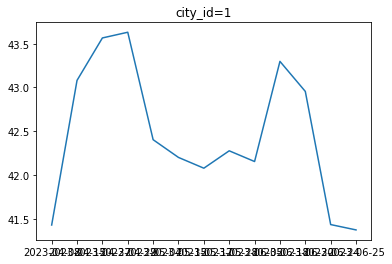

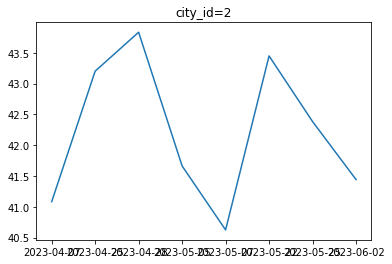

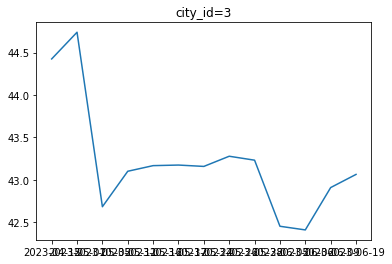

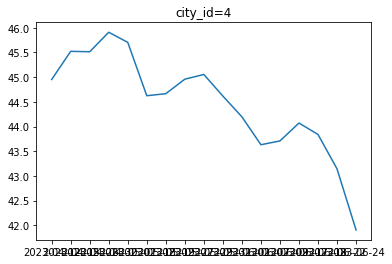

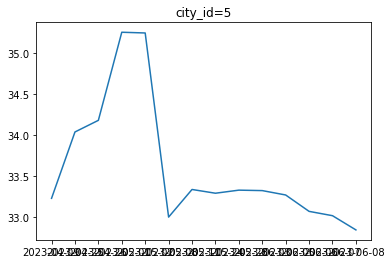

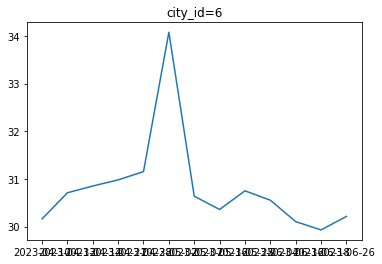

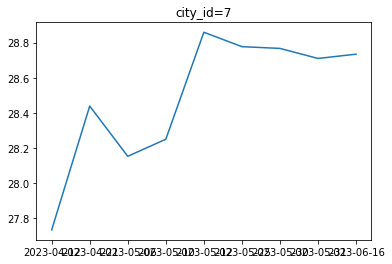

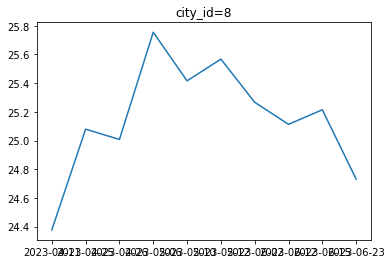

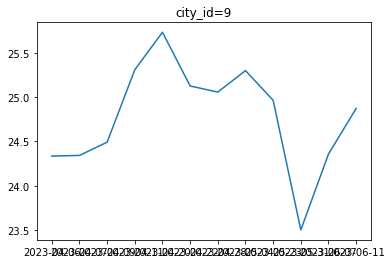

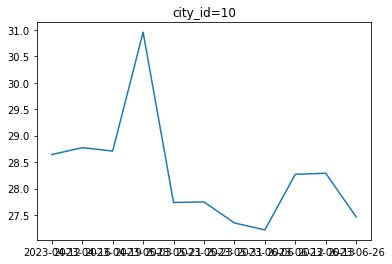

In [28]:
for city in range(1, 11):
    df1 = df[(df['city_id'] == city)]
    df1['subsidy_c_rate'] = df1['subsidy_c']/df1['gmv'].replace(0, np.nan)
    df1['gmv_pp'] = df1['gmv']/df1['user_cnt'].replace(0, np.nan)
    df1 = df1.sort_values(by=['dt', 'subsidy_c_rate']).drop_duplicates(subset=['dt'], keep='first')
    df1['gmv_pp'] = df1['gmv_pp'].rolling(7).mean()
    df1 = df1.loc[df1.index % 7 == 0, :]
    plt.plot(df1['dt'], df1['gmv_pp'])
    plt.title(f'city_id={city}')
    plt.show()

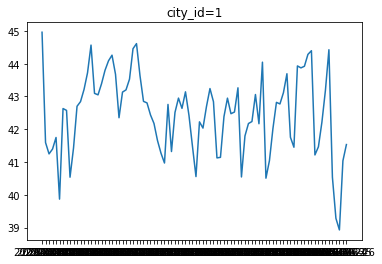

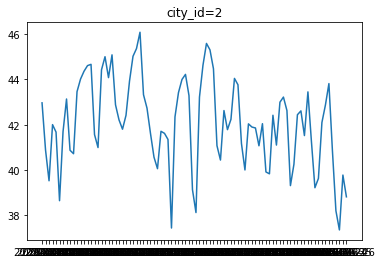

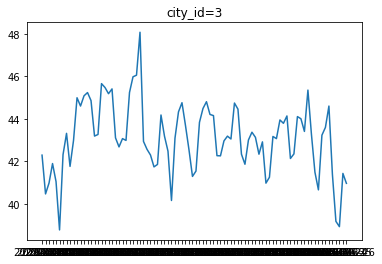

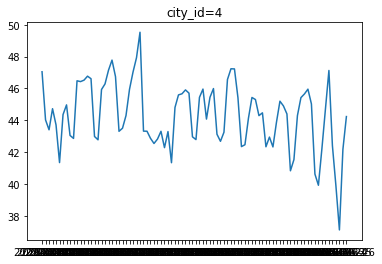

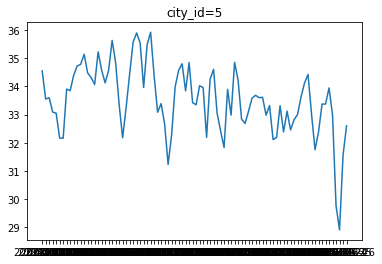

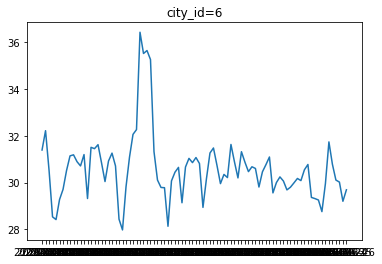

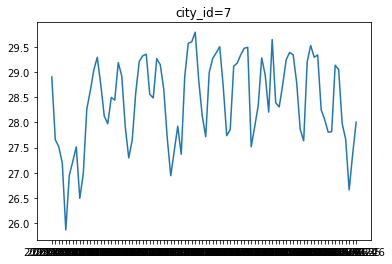

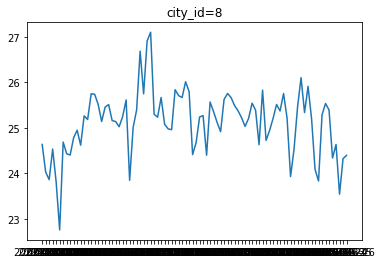

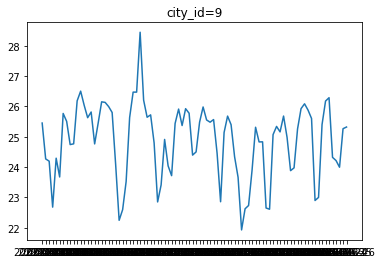

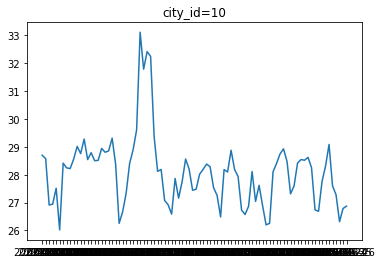

In [23]:
for city in range(1, 11):
    df1 = df[(df['city_id'] == city)]
    df1['subsidy_c_rate'] = df1['subsidy_c']/df1['gmv'].replace(0, np.nan)
    df1['gmv_pp'] = df1['gmv']/df1['user_cnt'].replace(0, np.nan)
    df1 = df1.sort_values(by=['dt', 'subsidy_c_rate']).drop_duplicates(subset=['dt'], keep='first')
    plt.plot(df1['dt'], df1['gmv_pp'])
    plt.title(f'city_id={city}')
    plt.show()

110


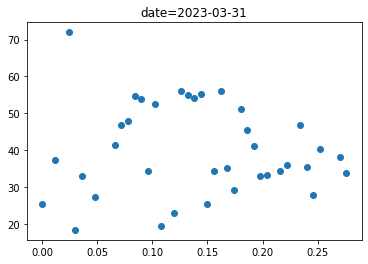

120


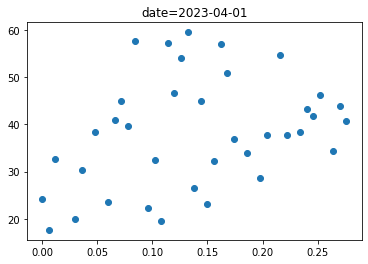

97


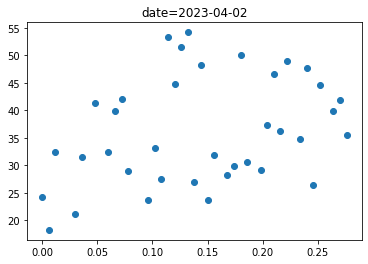

98


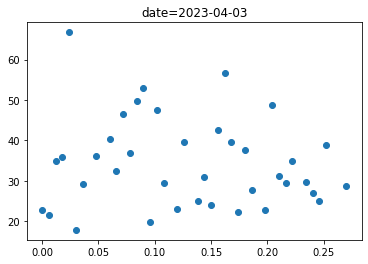

71


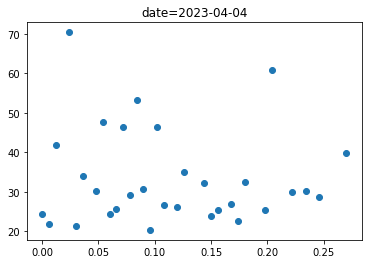

64


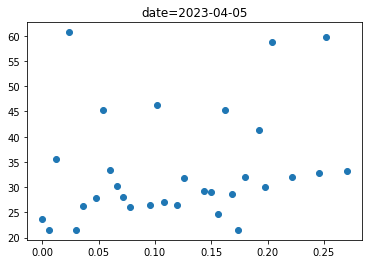

71


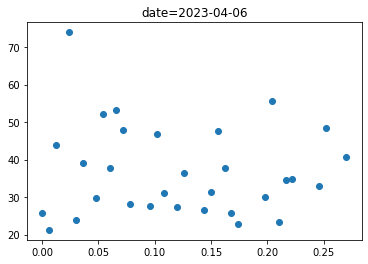

98


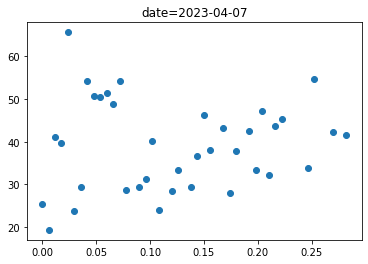

131


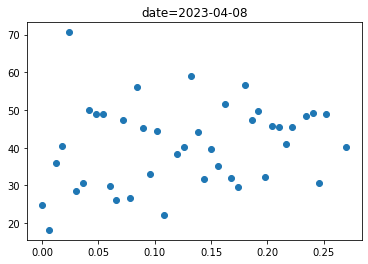

115


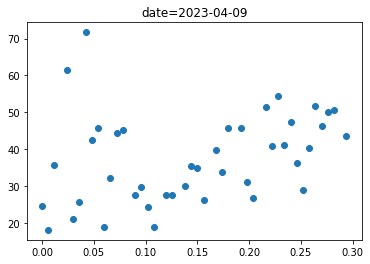

100


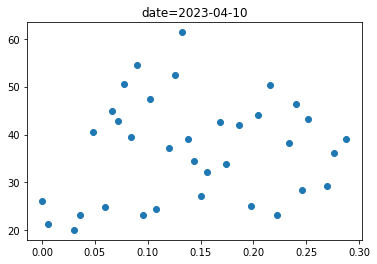

92


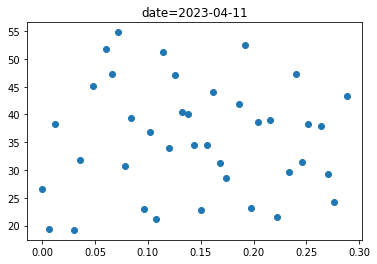

78


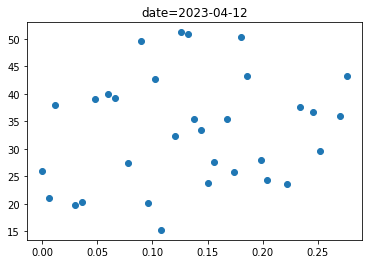

77


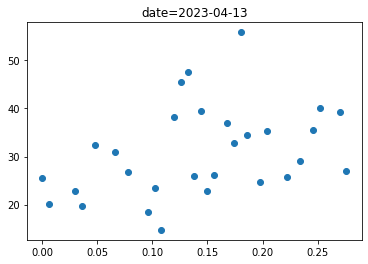

89


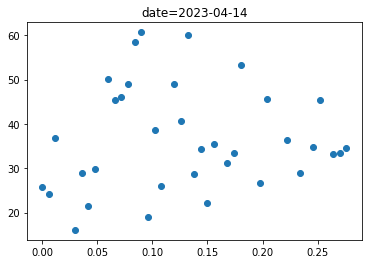

140


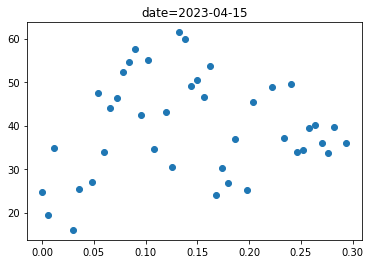

106


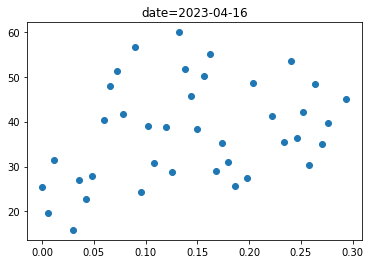

86


KeyboardInterrupt: 

In [9]:
for city in range(1, 11):
    df1 = df[(df['city_id'] == city) & (df['user_cnt'] > 100)]
    df1['subsidy_c_rate'] = df1['subsidy_c']/df1['gmv'].replace(0, np.nan)
    df1['gmv_pp'] = df1['gmv']/df1['user_cnt'].replace(0, np.nan)
    x_ls = np.linspace(0, 0.3, 51)
    y_ls = []
    for i in range(50):
        y = df1[(df1['subsidy_c_rate'] >= x_ls[i]) & (df1['subsidy_c_rate'] < x_ls[i + 1])]['gmv_pp'].median()
        y_ls.append(y)
    plt.scatter(x_ls[:-1], y_ls)
    plt.title(f'city_id={city}')
    plt.show()

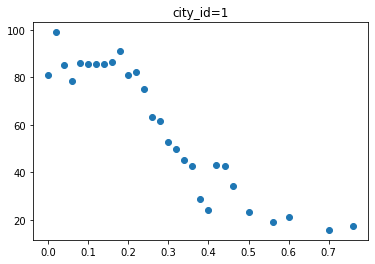

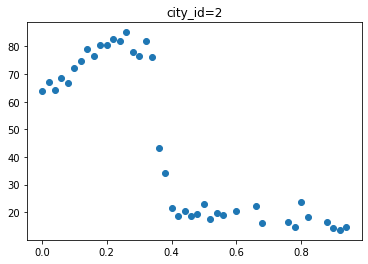

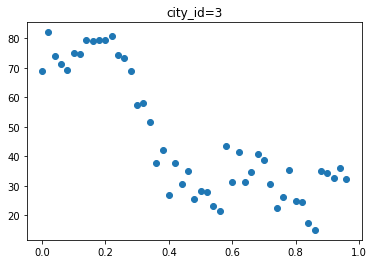

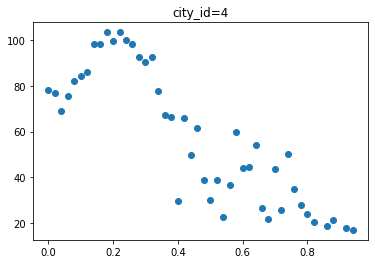

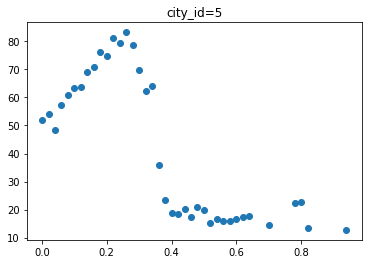

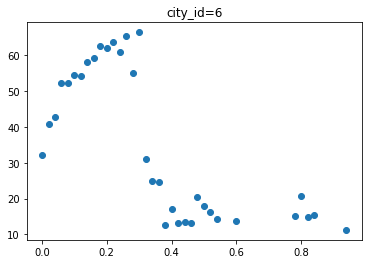

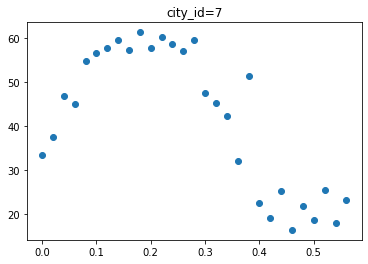

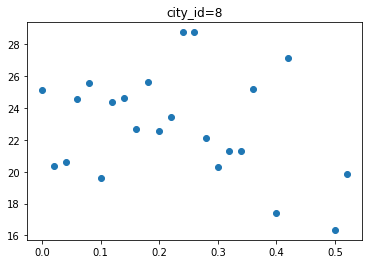

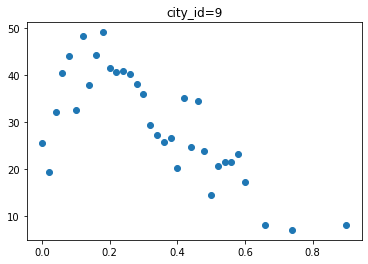

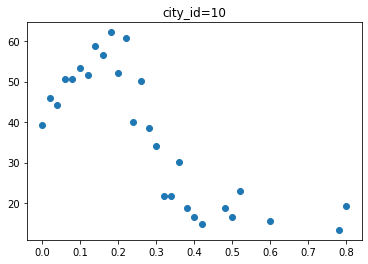

In [96]:
for city in range(1, 11):
    df1 = df[(df['city_id'] == city) & (df['user_cnt'] > 100)]
    df1['subsidy_c_rate'] = df1['subsidy_c']/df1['gmv'].replace(0, np.nan)
    df1['gmv_pp'] = df1['gmv']/df1['user_cnt'].replace(0, np.nan)
    x_ls = np.linspace(0, 1, 51)
    y_ls = []
    for i in range(50):
        y = df1[(df1['subsidy_c_rate'] >= x_ls[i]) & (df1['subsidy_c_rate'] < x_ls[i + 1])]['gmv_pp'].median()
        y_ls.append(y)
    plt.scatter(x_ls[:-1], y_ls)
    plt.title(f'city_id={city}')
    plt.show()